In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../..')
import aiohttp
import pandas as pd
import asyncio
import ccxt.async_support as ccxt
import ta
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from utilities.custom_indicators import get_n_columns, SmoothedHeikinAshi
from utilities.bt_analysis import get_metrics, backtest_analysis
from utilities.plot_analysis import plot_equity_vs_asset, plot_futur_simulations, plot_bar_by_month

In [3]:
async def get_coingecko_data():
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {"vs_currency": "USD", "per_page":250}

    async with aiohttp.ClientSession() as session:
        async with session.get(url, params=params) as response:
            data = await response.json()
            df = pd.DataFrame(data)
            df["symbol"] = df["symbol"].str.upper()
            return df

async def get_indicators_data(crypto_list, tf):
    exchange = ccxt.binance()
    try:
        markets = await exchange.load_markets()
        tasks = []
        symbol_list = []
        df_rsi = pd.DataFrame()

        for pair in markets.keys():
            if (
                markets[pair]["base"] in crypto_list
                and markets[pair]["quote"] == "USDT"
                and markets[pair]["spot"] == True
                and "USD" not in markets[pair]["base"]
            ):
                symbol_list.append(markets[pair]["base"])
                tasks.append(exchange.fetch_ohlcv(pair, tf, limit=1000))

        result = await asyncio.gather(*tasks)
        await exchange.close()
        crypto_count = 0
        for i in range(len(symbol_list)):
            symbol = symbol_list[i]
            # print(symbol)
            df = pd.DataFrame(
                result[i], columns=["date", "open", "high", "low", "close", "volume"]
            )
            df["date"] = pd.to_datetime(df["date"], unit="ms")
            df = df.set_index(df["date"], drop=True)
            if symbol == "BTC":
                initial_btc_price = df.loc[df.index.min()]["close"]
            if len(df) < 1000 or df.index.max().date() != datetime.now().date():
                continue
            crypto_count += 1
            if crypto_count > 51:
                break
            df["rsi"] = ta.momentum.rsi(df["close"], window=14)
            df["mm_100"] = ta.trend.sma_indicator(df["close"], window=100)
            df["distance_mm_100"] = (df["close"] - df["mm_100"]) / df["mm_100"]
            # df["mm_200"] = ta.trend.sma_indicator(df["close"], window=200)
            df_rsi[f"rsi_{symbol}"] = df["rsi"]
            df_rsi[f"return_{symbol}"] = df["close"].pct_change()
            df_rsi[f"90_return_{symbol}"] = df["close"].pct_change(90)
            df_rsi[f"7_return_{symbol}"] = df["close"].pct_change(7)
            df_rsi[f"distance_mm_100_{symbol}"] = df["distance_mm_100"]
        
        return df_rsi, initial_btc_price
    except Exception as e:
        await exchange.close()
        raise e
    
async def get_full_df():
    df_cg = await get_coingecko_data()
    symbols = list(df_cg["symbol"])
    print(symbols)
    df, initial_btc_price = await get_indicators_data(symbols, "1d")
    return df, initial_btc_price
    

df, initial_btc_price = await get_full_df()

['BTC', 'ETH', 'USDT', 'XRP', 'BNB', 'SOL', 'USDC', 'DOGE', 'ADA', 'TRX', 'STETH', 'WBTC', 'LINK', 'AVAX', 'XLM', 'SHIB', 'LEO', 'TON', 'WSTETH', 'HBAR', 'USDS', 'SUI', 'LTC', 'DOT', 'OM', 'BCH', 'BGB', 'WETH', 'PI', 'HYPE', 'USDE', 'BSC-USD', 'WEETH', 'UNI', 'WBT', 'XMR', 'PEPE', 'APT', 'NEAR', 'DAI', 'SUSDS', 'SUSDE', 'ICP', 'OKB', 'ONDO', 'GT', 'CRO', 'TKX', 'AAVE', 'MNT', 'ETC', 'CBBTC', 'FDUSD', 'TRUMP', 'VET', 'TAO', 'ENA', 'ATOM', 'RENDER', 'POL', 'TIA', 'FIL', 'KAS', 'S', 'BUIDL', 'LBTC', 'ARB', 'ALGO', 'FTN', 'IP', 'USDT0', 'JUP', 'FET', 'OP', 'KCS', 'SOLVBTC', 'MOVE', 'WETH', 'RSETH', 'IMX', 'BONK', 'NEXO', 'WLD', 'MKR', 'XDC', 'BNSOL', 'QNT', 'STX', 'INJ', 'SEI', 'GRT', 'USDC.E', 'THETA', 'RETH', 'DEXE', 'LDO', 'USD0', 'FLR', 'EOS', 'BERA', 'SOLVBTC.BBN', 'GALA', 'USDT', 'METH', 'WBNB', 'PYUSD', 'JTO', 'XTZ', 'SAND', 'IOTA', 'USDC', 'XAUT', 'CRV', 'FLOKI', 'BTT', 'WBTC', 'BSV', 'MSOL', 'CAKE', 'FLOW', 'PAXG', 'KAIA', 'JASMY', 'PYTH', 'EZETH', 'USDX', 'HNT', 'ZEC', 'SPX', 'FA

In [4]:
df

,rsi_BTC,return_BTC,90_return_BTC,7_return_BTC,distance_mm_100_BTC,rsi_ETH,return_ETH,90_return_ETH,7_return_ETH,distance_mm_100_ETH,...,rsi_INJ,return_INJ,90_return_INJ,7_return_INJ,distance_mm_100_INJ,rsi_AXS,return_AXS,90_return_AXS,7_return_AXS,distance_mm_100_AXS
date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-02,NaN,-0.001400,NaN,NaN,NaN,NaN,0.006870,NaN,NaN,NaN,...,NaN,0.005902,NaN,NaN,NaN,NaN,-0.007829,NaN,NaN,NaN
2022-07-03,NaN,0.003273,NaN,NaN,NaN,NaN,0.006795,NaN,NaN,NaN,...,NaN,0.015926,NaN,NaN,NaN,NaN,0.017217,NaN,NaN,NaN
2022-07-04,NaN,0.047675,NaN,NaN,NaN,NaN,0.071435,NaN,NaN,NaN,...,NaN,0.028053,NaN,NaN,NaN,NaN,0.049365,NaN,NaN,NaN
2022-07-05,NaN,-0.003008,NaN,NaN,NaN,NaN,-0.016073,NaN,NaN,NaN,...,NaN,0.003210,NaN,NaN,NaN,NaN,-0.028898,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-22,45.283129,-0.002952,-0.119195,-0.005903,-0.118019,41.261790,0.007600,-0.396468,0.022466,-0.317629,...,40.990584,0.021672,-0.515181,-0.026549,-0.436122,46.259797,0.028658,-0.432140,0.033960,-0.331101
2025-03-23,49.565749,0.026740,-0.092736,0.042482,-0.092970,42.893918,0.012773,-0.413887,0.063058,-0.304357,...,41.400677,0.005051,-0.569264,0.037539,-0.426979,44.745981,-0.016129,-0.500447,0.057026,-0.335926
2025-03-24,52.114446,0.016445,-0.113167,0.041520,-0.076700,47.558852,0.037493,-0.404210,0.080408,-0.273770,...,45.857981,0.055276,-0.549356,0.054217,-0.389350,49.854770,0.047392,-0.489911,0.024490,-0.298888


In [5]:
cols_rsi_alt = [col for col in df.columns if col.startswith("rsi_") and "BTC" not in col]
cols_return_alt = [col for col in df.columns if col.startswith("return_") and "BTC" not in col]
cols_90_return_alt = [col for col in df.columns if col.startswith("90_return_") and "BTC" not in col]
cols_7_return_alt = [col for col in df.columns if col.startswith("7_return_") and "BTC" not in col]
cols_distance_mm_100_alt = [col for col in df.columns if col.startswith("distance_mm_100_") and "BTC" not in col]
df["mean_rsi_alt"] = df[cols_rsi_alt].mean(axis=1)
df["mean_return_alt"] = df[cols_return_alt].mean(axis=1)
df["mean_90_return_alt"] = df[cols_90_return_alt].mean(axis=1)
df["mean_7_return_alt"] = df[cols_7_return_alt].mean(axis=1)
df["alt_season_index"] = df[cols_90_return_alt].gt(df["90_return_BTC"], axis=0).sum(axis=1)
df["alt_7_return_index"] = df[cols_7_return_alt].gt(df["7_return_BTC"], axis=0).sum(axis=1)
df["alt_rsi_index"] = df[cols_rsi_alt].gt(df["rsi_BTC"], axis=0).sum(axis=1)
df["alt_distance_mm_100_index"] = df[cols_distance_mm_100_alt].gt(df["distance_mm_100_BTC"], axis=0).sum(axis=1)
df


,rsi_BTC,return_BTC,90_return_BTC,7_return_BTC,distance_mm_100_BTC,rsi_ETH,return_ETH,90_return_ETH,7_return_ETH,distance_mm_100_ETH,...,7_return_AXS,distance_mm_100_AXS,mean_rsi_alt,mean_return_alt,mean_90_return_alt,mean_7_return_alt,alt_season_index,alt_7_return_index,alt_rsi_index,alt_distance_mm_100_index
date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2022-07-02,NaN,-0.001400,NaN,NaN,NaN,NaN,0.006870,NaN,NaN,NaN,...,NaN,NaN,NaN,0.013484,NaN,NaN,0,0,0,0
2022-07-03,NaN,0.003273,NaN,NaN,NaN,NaN,0.006795,NaN,NaN,NaN,...,NaN,NaN,NaN,0.006851,NaN,NaN,0,0,0,0
2022-07-04,NaN,0.047675,NaN,NaN,NaN,NaN,0.071435,NaN,NaN,NaN,...,NaN,NaN,NaN,0.045315,NaN,NaN,0,0,0,0
2022-07-05,NaN,-0.003008,NaN,NaN,NaN,NaN,-0.016073,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.020329,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-22,45.283129,-0.002952,-0.119195,-0.005903,-0.118019,41.261790,0.007600,-0.396468,0.022466,-0.317629,...,0.033960,-0.331101,45.617128,0.010891,-0.357493,0.008289,6,29,22,6
2025-03-23,49.565749,0.026740,-0.092736,0.042482,-0.092970,42.893918,0.012773,-0.413887,0.063058,-0.304357,...,0.057026,-0.335926,46.311999,0.008681,-0.394980,0.057927,4,26,10,6
2025-03-24,52.114446,0.016445,-0.113167,0.041520,-0.076700,47.558852,0.037493,-0.404210,0.080408,-0.273770,...,0.024490,-0.298888,49.983953,0.038077,-0.398836,0.055241,5,28,13,6


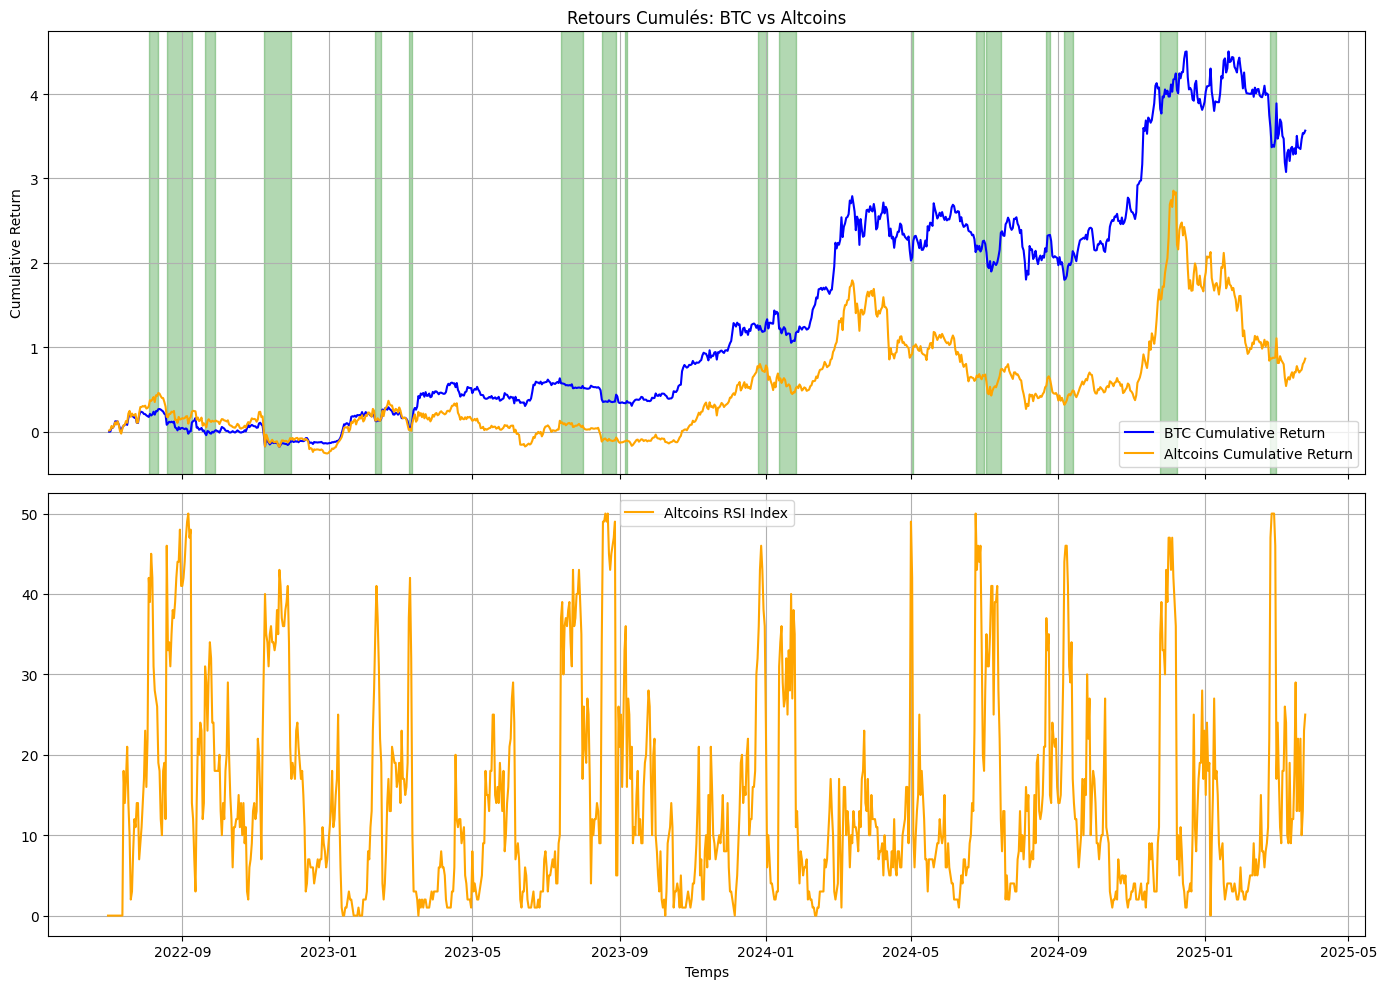

In [6]:
# --- 1. Calcul des retours cumulés ---

# Retour cumulé de BTC
df["cum_return_BTC"] = (1 + df["return_BTC"]).cumprod() - 1

# Retour cumulé des altcoins (à partir du rendement moyen)
df["cum_return_alt"] = (1 + df["mean_return_alt"]).cumprod() - 1

# --- 2. Création des graphiques ---

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Graphique du retour cumulé
ax1.plot(df.index, df["cum_return_BTC"], label="BTC Cumulative Return", color="blue")
ax1.plot(df.index, df["cum_return_alt"], label="Altcoins Cumulative Return", color="orange")


# open_condition = df["alt_7_return_index"] > 45
# close_condition = df["alt_7_return_index"] < 45

# open_condition = df["mean_rsi_alt"] > df["rsi_BTC"]
# close_condition = df["mean_rsi_alt"] < df["rsi_BTC"]
# ax2.plot(df.index, df["rsi_BTC"], label="BTC RSI", color="blue")
# ax2.plot(df.index, df["mean_rsi_alt"], label="Altcoins Mean RSI", color="orange")


open_condition = df["alt_rsi_index"] > 30
close_condition = df["alt_rsi_index"] < 20
ax2.plot(df.index, df["alt_rsi_index"], label="Altcoins RSI Index", color="orange")

# open_condition = df["alt_season_index"] > 30
# close_condition = df["alt_season_index"] < 20
# ax2.plot(df.index, df["alt_season_index"], label="Alt Season Index", color="orange")

# open_condition = df["alt_distance_mm_100_index"] > 30
# close_condition = df["alt_distance_mm_100_index"] < 20
# ax2.plot(df.index, df["alt_distance_mm_100_index"], label="Alt Distance MM 100 Index", color="orange")

periods = pd.DataFrame(index=df.index)
periods['in_position'] = False

# Initialisation de la position
in_position = False
start_date = None

# Parcours des données pour identifier les périodes
for date in df.index:
    if not in_position and open_condition[date]:
        # Début d'une nouvelle période
        in_position = True
        start_date = date
    elif in_position and close_condition[date]:
        # Fin d'une période
        in_position = False
        # Ajout de la zone verte
        ax1.axvspan(start_date, date, color='green', alpha=0.3)

# Si on est encore en position à la fin, on ferme jusqu'à la dernière date
if in_position:
    ax1.axvspan(start_date, df.index[-1], color='green', alpha=0.3)



ax1.set_title("Retours Cumulés: BTC vs Altcoins")
ax1.set_ylabel("Cumulative Return")
ax1.legend()
ax1.grid(True)


ax2.set_xlabel("Temps")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [7]:
class Strategy:
    def __init__(
        self,
        df_list,
        oldest_pair,
        type=["long"],
        params={},
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

    def populate_indicators(self):
        for position_id in self.df_list:
            params = self.params[position_id]
            df = self.df_list[position_id]
            self.df_list[position_id] = df

        return self.df_list[self.oldest_pair]

    def populate_buy_sell(self):
        full_list = []
        for pair, df in self.df_list.items():
            params = self.params[pair]
            df["pair"] = pair
            full_list.append(df)

        df_full = pd.concat(full_list)
        df_full = df_full.sort_index()
        self.open_long_obj = (
            # df_full[(df_full["rsi"] > df_full["rsi_other"])]
            df_full[(df_full["alt_rsi_index"] > 30)]
            # df_full[(df_full["alt_season_index"] > 30)]
            # df_full[(df_full["alt_distance_mm_100_index"] > 30)]
            # df_full[(df_full["alt_7_return_index"] > 40)]
            .groupby("date")["pair"]
            .apply(list)
            .to_dict()
            if self.use_long
            else {}
        )
        self.close_long_obj = (
            # df_full[(df_full["rsi"] < df_full["rsi_other"])]
            df_full[(df_full["alt_rsi_index"] < 20)]
            # df_full[(df_full["alt_season_index"] < 20)]
            # df_full[(df_full["alt_distance_mm_100_index"] < 20)]
            # df_full[(df_full["alt_7_return_index"] < 10)]
            .groupby("date")["pair"]
            .apply(list)
            .to_dict()
            if self.use_long
            else {}
        )
        self.open_short_obj = (
            # df_full[(df_full["rsi"] < df_full["rsi_other"])]
            df_full[(df_full["alt_rsi_index"] < 20)]
            # df_full[(df_full["alt_season_index"] < 20)]
            # df_full[(df_full["alt_distance_mm_100_index"] < 20)]
            # df_full[(df_full["alt_7_return_index"] < 10)]
            .groupby("date")["pair"]
            .apply(list)
            .to_dict()
            if self.use_short
            else {}
        )
        self.close_short_obj = (
            # df_full[(df_full["rsi"] > df_full["rsi_other"])]
            df_full[(df_full["alt_rsi_index"] > 30)]
            # df_full[(df_full["alt_season_index"] > 30)]
            # df_full[(df_full["alt_distance_mm_100_index"] > 30)]
            # df_full[(df_full["alt_7_return_index"] > 40)]
            .groupby("date")["pair"]
            .apply(list)
            .to_dict()
            if self.use_short
            else {}
        )

        return self.df_list[self.oldest_pair]

    def run_backtest(self, initial_wallet=1000, leverage=1):
        params = self.params
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        long_exposition = 0
        short_exposition = 0
        maker_fee = 0.0002
        taker_fee = 0.0006
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_positions = {}

        for index, ini_row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for position_id in current_positions:
                    row = self.df_list[position_id].loc[index]
                    position = current_positions[position_id]
                    if position["side"] == "LONG":
                        close_price = row["open"]
                        trade_result = (close_price - position["price"]) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position["size"] - fee
                    elif position["side"] == "SHORT":
                        close_price = row["open"]
                        trade_result = (position["price"] - close_price) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position["size"] - fee

                days.append(
                    {
                        "day": str(index.year)
                        + "-"
                        + str(index.month)
                        + "-"
                        + str(index.day),
                        "wallet": temp_wallet,
                        "price": ini_row["open"],
                        "long_exposition": 0,
                        "short_exposition": 0,
                        "risk": 0,
                    }
                )
            previous_day = current_day

            close_long_row = (
                self.close_long_obj[index] if index in self.close_long_obj else []
            )
            close_short_row = (
                self.close_short_obj[index] if index in self.close_short_obj else []
            )
            if len(current_positions) > 0:
                # -- Close LONG --
                long_position_to_close = set(
                    {k: v for k, v in current_positions.items() if v["side"] == "LONG"}
                ).intersection(set(close_long_row))
                for position_id in long_position_to_close:
                    row = self.df_list[position_id].loc[index]
                    position = current_positions[position_id]
                    close_price = row["close"]
                    trade_result = (close_price - position["price"]) / position["price"]
                    close_size = position["size"] + position["size"] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - position["size"] - fee
                    trades.append(
                        {
                            "pair": position_id,
                            "open_date": position["date"],
                            "close_date": index,
                            "position": position["side"],
                            "open_reason": position["reason"],
                            "close_reason": "Market",
                            "open_price": position["price"],
                            "close_price": close_price,
                            "open_fee": position["fee"],
                            "close_fee": fee,
                            "open_trade_size": position["size"],
                            "close_trade_size": close_size,
                            "wallet": wallet,
                        }
                    )
                    del current_positions[position_id]

                # -- Close SHORT --
                short_position_to_close = set(
                    {k: v for k, v in current_positions.items() if v["side"] == "SHORT"}
                ).intersection(set(close_short_row))
                for position_id in short_position_to_close:
                    row = self.df_list[position_id].loc[index]
                    position = current_positions[position_id]
                    close_price = row["close"]
                    trade_result = (position["price"] - close_price) / position["price"]
                    close_size = position["size"] + position["size"] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - position["size"] - fee
                    trades.append(
                        {
                            "pair": position_id,
                            "open_date": position["date"],
                            "close_date": index,
                            "position": position["side"],
                            "open_reason": position["reason"],
                            "close_reason": "Market",
                            "open_price": position["price"],
                            "close_price": close_price,
                            "open_fee": position["fee"],
                            "close_fee": fee,
                            "open_trade_size": position["size"],
                            "close_trade_size": close_size,
                            "wallet": wallet,
                        }
                    )
                    del current_positions[position_id]

            # -- Check for opening position --
            # -- Open LONG --
            open_long_row = (
                self.open_long_obj[index] if index in self.open_long_obj else []
            )
            for position_id in open_long_row:
                if position_id not in current_positions:
                    row = self.df_list[position_id].loc[index]
                    open_price = row["close"]
                    pos_size = 0.5 * wallet * leverage
                    fee = pos_size * taker_fee
                    pos_size -= fee
                    wallet -= fee
                    current_positions[position_id] = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee": fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                    long_exposition += 0
            # -- Open SHORT --
            open_short_row = (
                self.open_short_obj[index] if index in self.open_short_obj else []
            )
            for position_id in open_short_row:
                if position_id not in current_positions:
                    row = self.df_list[position_id].loc[index]
                    open_price = row["close"]
                    pos_size = 0.5 * wallet * leverage
                    fee = pos_size * taker_fee
                    pos_size -= fee
                    wallet -= fee
                    current_positions[position_id] = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee": fee,
                        "reason": "Market",
                        "side": "SHORT",
                    }
                    short_exposition += 0

        if len(trades) == 0:
            raise ValueError("No trades have been made")

        df_days = pd.DataFrame(days)
        df_days["day"] = pd.to_datetime(df_days["day"])
        df_days = df_days.set_index(df_days["day"])

        df_trades = pd.DataFrame(trades)
        df_trades["open_date"] = pd.to_datetime(df_trades["open_date"])
        df_trades = df_trades.set_index(df_trades["open_date"])

        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days,
        }

In [8]:
df_list = {}
df_btc = df.copy()[
    [
        "rsi_BTC",
        "cum_return_BTC",
        "mean_rsi_alt",
        "alt_rsi_index",
        "alt_season_index",
        "alt_distance_mm_100_index",
        "alt_7_return_index",
    ]
].rename(
    columns={
        "rsi_BTC": "rsi",
        "cum_return_BTC": "cum_return",
        "mean_rsi_alt": "rsi_other",
    }
)
df_btc["close"] = (1 + df_btc["cum_return"]) * initial_btc_price
df_btc["open"] = df_btc["close"].shift(1)
df_btc["alt_rsi_index"] = 50 - df_btc["alt_rsi_index"]
df_btc["alt_season_index"] = 50 - df_btc["alt_season_index"]
df_btc["alt_distance_mm_100_index"] = 50 - df_btc["alt_distance_mm_100_index"]
df_btc["alt_7_return_index"] = 50 - df_btc["alt_7_return_index"]
df_btc = df_btc.dropna()

df_alt = df.copy()[
    [
        "mean_rsi_alt",
        "cum_return_alt",
        "rsi_BTC",
        "alt_rsi_index",
        "alt_season_index",
        "alt_distance_mm_100_index",
        "alt_7_return_index",
    ]
].rename(
    columns={
        "mean_rsi_alt": "rsi",
        "cum_return_alt": "cum_return",
        "rsi_BTC": "rsi_other",
    }
)
df_alt["close"] = (1 + df_alt["cum_return"]) * initial_btc_price
df_alt["open"] = df_alt["close"].shift(1)
df_alt = df_alt.dropna()

df_list["BTC"] = df_btc
df_list["ALT"] = df_alt

df_btc

,rsi,cum_return,rsi_other,alt_rsi_index,alt_season_index,alt_distance_mm_100_index,alt_7_return_index,close,open
date,,,,,,,,,
2022-07-14,57.248659,0.067897,53.738472,32,50,50,28,20588.84,20234.87
2022-07-15,59.641389,0.080407,54.457290,36,50,50,16,20830.04,20588.84
2022-07-16,63.019564,0.099368,59.958566,33,50,50,22,21195.60,20830.04
2022-07-17,57.394662,0.078754,56.332631,29,50,50,19,20798.16,21195.60
2022-07-18,69.464898,0.163528,66.080775,36,50,50,12,22432.58,20798.16
...,...,...,...,...,...,...,...,...,...
2025-03-22,45.283129,3.348623,45.617128,28,44,44,21,83840.59,84088.79
2025-03-23,49.565749,3.464906,46.311999,40,46,44,24,86082.50,83840.59
2025-03-24,52.114446,3.538333,49.983953,37,45,44,22,87498.16,86082.50


In [9]:
strat = Strategy(
    df_list,
    "BTC",
    type=["long", "short"],
    params={"BTC":{}, "ALT":{}},
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)

df_trades, df_days = backtest_analysis(
    trades=bt_result["trades"],
    days=bt_result["days"],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=True,
    pair_info=True,
    indepedant_trade=True,
    pair_exposition_info=True,
)

Period: [2022-07-14 00:00:00] -> [2025-03-26 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 1524.8 $
Performance: 52.48 %
Sharpe Ratio: 0.79 | Sortino Ratio: 1.0 | Calmar Ratio: 0.64
Worst Drawdown T|D: -39.89% | -28.7%
Buy and hold performance: 331.89 %
Performance vs buy and hold: -64.69 %
Total trades on the period: 72
Average Profit: 1.33 %
Global Win rate: 50.0 %

--- Trades Information ---
Mean Trades per day: 0.07
Mean Trades Duration: 26 days 17:20:00
Best trades: +65.91 % the 2023-09-07 00:00:00 -> 2023-12-25 00:00:00 (BTC)
Worst trades: -98.36 % the 2023-09-07 00:00:00 -> 2023-12-25 00:00:00 (ALT)
Total Good trades on the period: 36
Total Bad trades on the period: 36
Average Good Trades result: 15.01 %
Average Bad Trades result: -12.36 %
Mean Good Trades Duration: 29 days 22:40:00
Mean Bad Trades Duration: 23 days 12:00:00

--- Days Informations ---
Total: 987 days recorded
Winning days: 514 days (52.08%)
Neutral days: 1 days (0.1%)
Loosing days

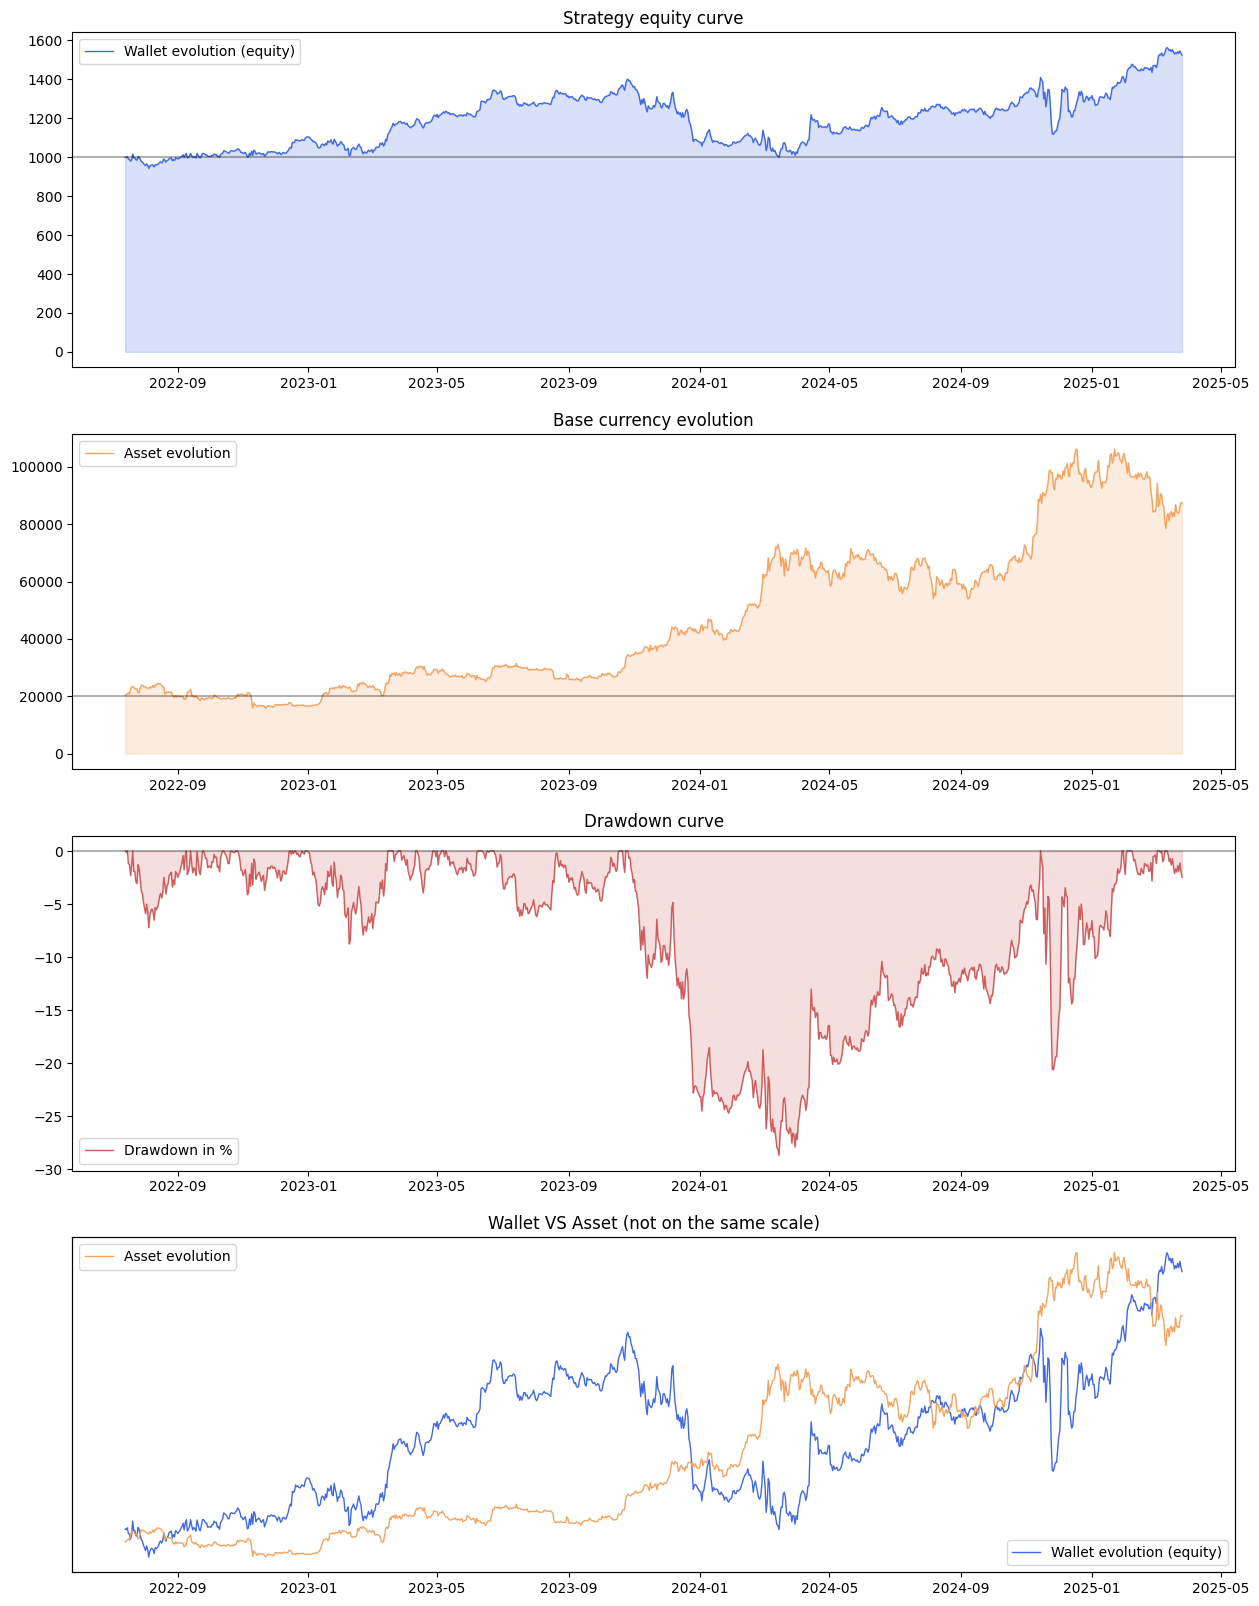

In [10]:
plot_equity_vs_asset(df_days=df_days.loc[:])

In [11]:
df_trades

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,trades_duration,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,,
2022-07-14,BTC,2022-07-14,2022-08-04,LONG,Market,Market,20588.840000,22622.980000,0.300000,0.329442,499.700000,549.069452,1048.440101,49.069452,0.098198,0.044710,21 days,1048.440101,0.000000,0.000000
2022-07-14,ALT,2022-07-14,2022-08-04,SHORT,Market,Market,20734.963180,25060.047515,0.299910,0.237210,499.550090,395.349458,944.002259,-104.500542,-0.209189,-0.124479,21 days,1048.440101,104.437842,0.099613
2022-08-04,ALT,2022-08-04,2022-08-12,LONG,Market,Market,25060.047515,28108.626374,0.283201,0.317462,471.717929,529.102868,1000.503420,57.101739,0.121051,0.053992,8 days,1048.440101,47.936681,0.045722
2022-08-04,BTC,2022-08-04,2022-08-12,SHORT,Market,Market,22622.980000,24403.680000,0.283116,0.260675,471.576413,434.457691,963.124023,-37.401838,-0.079312,-0.040403,8 days,1048.440101,85.316078,0.081374
2022-08-12,BTC,2022-08-12,2022-08-19,LONG,Market,Market,24403.680000,20834.390000,0.288937,0.246529,481.273074,410.881921,891.908553,-70.680090,-0.146861,-0.086066,7 days,1048.440101,156.531548,0.149299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25,BTC,2024-11-25,2024-12-09,SHORT,Market,Market,93010.010000,97276.470000,0.335819,0.320222,559.362164,533.703675,1235.255867,-25.994308,-0.046471,-0.021496,14 days,1717.282360,482.026493,0.280691
2024-12-09,BTC,2024-12-09,2025-02-25,LONG,Market,Market,97276.470000,88680.400000,0.370577,0.337627,617.257357,562.711921,1179.631761,-54.916013,-0.088968,-0.048827,78 days,1717.282360,537.650598,0.313082
2024-12-09,ALT,2024-12-09,2025-02-25,SHORT,Market,Market,61987.269072,36044.613975,0.370466,0.525196,617.072179,875.326672,1437.361058,257.884027,0.417915,0.152122,78 days,1717.282360,279.921302,0.163002


In [12]:
for index, row in df_trades.iterrows():
    if row["pair"] == "ALT":
        two_trades = df_trades.loc[index]
        if len(two_trades) == 2:
            t1 = two_trades.iloc[0]
            t2 = two_trades.iloc[1]
            print(
                f"{index} {t1["position"]} {t1["pair"]} - {t2["position"]} {t2["pair"]} : {round(((t1["trade_result"] + t2["trade_result"]) / (t1["open_trade_size"]*2)) * 100, 2)} %"
            )

2022-07-14 00:00:00 LONG BTC - SHORT ALT : -5.55 %
2022-08-04 00:00:00 LONG ALT - SHORT BTC : 2.09 %
2022-08-12 00:00:00 LONG BTC - SHORT ALT : 2.34 %
2022-08-19 00:00:00 LONG ALT - SHORT BTC : 1.32 %
2022-09-09 00:00:00 LONG BTC - SHORT ALT : 0.41 %
2022-09-20 00:00:00 LONG ALT - SHORT BTC : 0.43 %
2022-09-28 00:00:00 LONG BTC - SHORT ALT : 2.8 %
2022-11-08 00:00:00 LONG ALT - SHORT BTC : -0.8 %
2022-12-01 00:00:00 LONG BTC - SHORT ALT : 1.85 %
2023-02-09 00:00:00 LONG ALT - SHORT BTC : 0.48 %
2023-02-14 00:00:00 LONG BTC - SHORT ALT : 2.02 %
2023-03-09 00:00:00 LONG ALT - SHORT BTC : 0.18 %
2023-03-12 00:00:00 LONG BTC - SHORT ALT : 19.06 %
2023-07-14 00:00:00 LONG ALT - SHORT BTC : -0.51 %
2023-08-01 00:00:00 LONG BTC - SHORT ALT : 3.52 %
2023-08-17 00:00:00 LONG ALT - SHORT BTC : 0.58 %
2023-08-29 00:00:00 LONG BTC - SHORT ALT : -1.12 %
2023-09-05 00:00:00 LONG ALT - SHORT BTC : -0.36 %
2023-09-07 00:00:00 LONG BTC - SHORT ALT : -16.21 %
2023-12-25 00:00:00 LONG ALT - SHORT BTC : -

----- 2022 Cumulative Performances: 10.45% -----


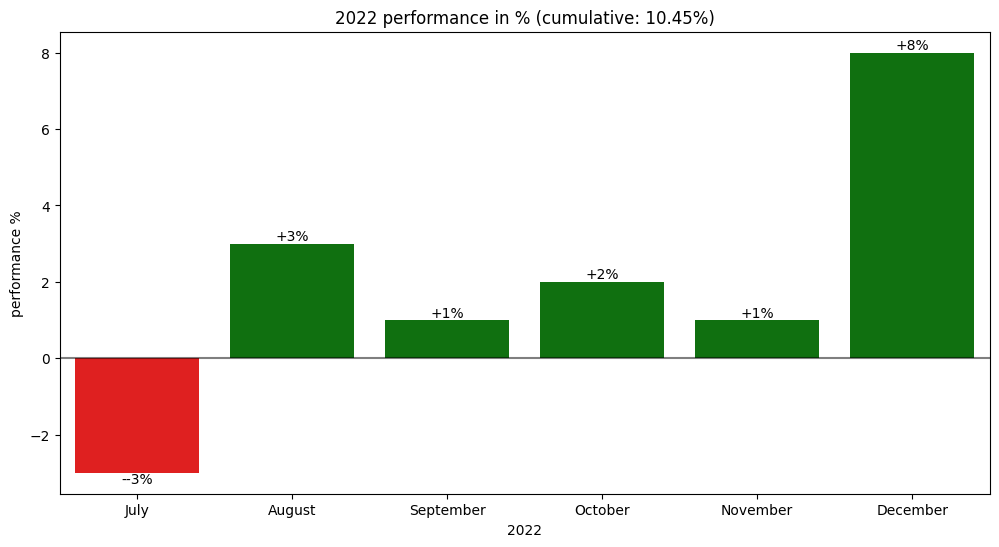

----- 2023 Cumulative Performances: -2.06% -----


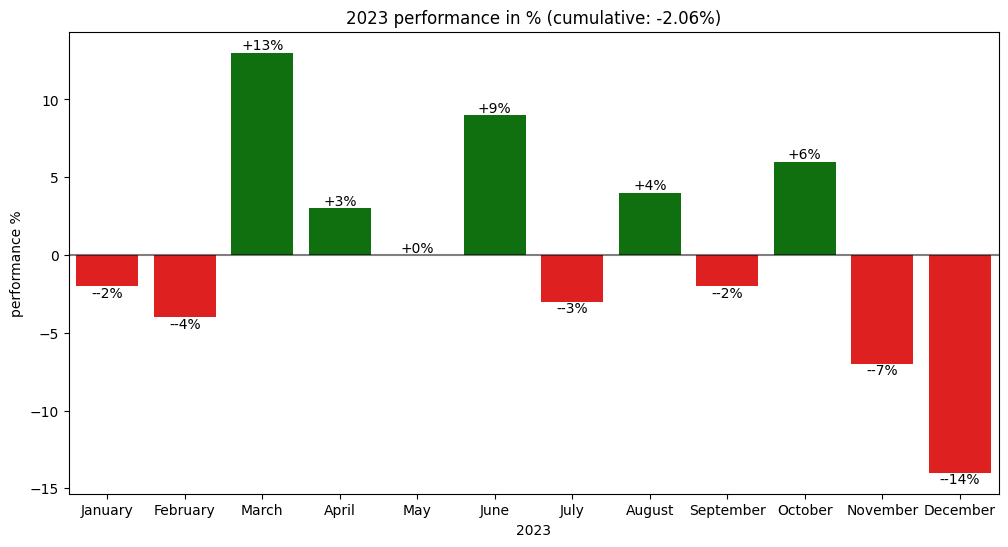

----- 2024 Cumulative Performances: 21.17% -----


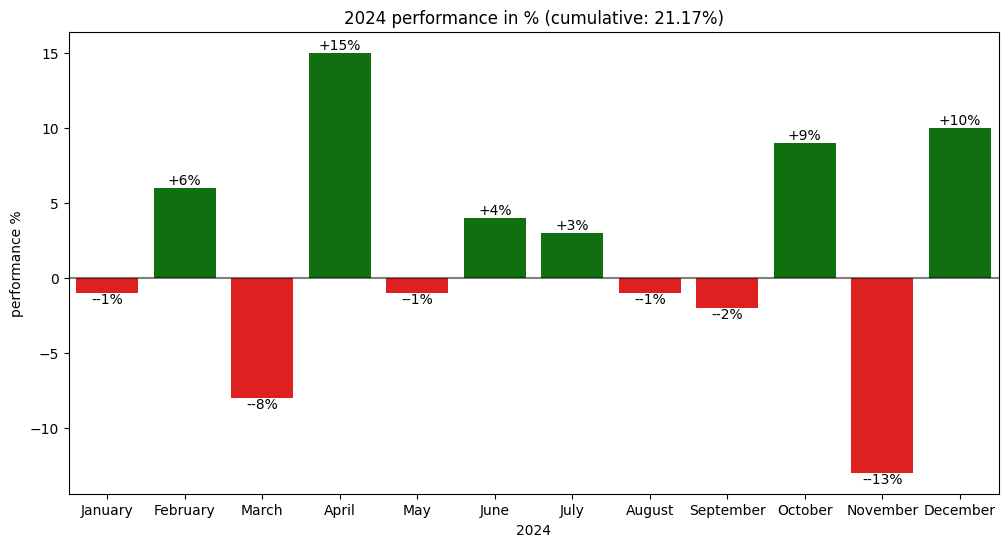

----- 2025 Cumulative Performances: 15.83% -----


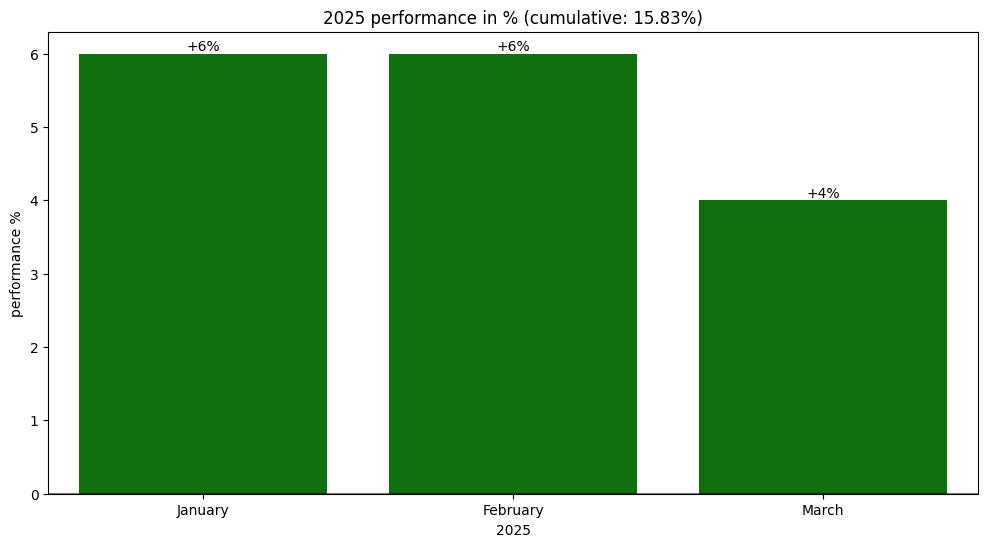

In [13]:
plot_bar_by_month(df_days=df_days)